In [ ]:
import lightning.pytorch as pl
from src.models.ndt1_wrapper import NDT1SSLModule
import numpy as np
import torch
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import pysindy as ps
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessing.prp import add_perceived_probs
from preprocessing.wheel import wheel_to_angles
import sys
import src.models.ndt1_wrapper as real_mod
import warnings

sys.modules['models.ndt1_wrapper'] = real_mod
pl.seed_everything(654)

# 128 D 2 L
# ckpt_path = "./mlruns_07_01/346362216954362618/fa251add30e44cc7815c03d3494a4f74/artifacts/epoch=78-step=474/epoch=78-step=474.ckpt" # 0.52 / 0.55
# https://lx619lhl-5000.euw.devtunnels.ms/#/experiments/346362216954362618/runs/fa251add30e44cc7815c03d3494a4f74/model-metrics


# 128 D 2 L
# ckpt_path = "./mlruns_07_01/346362216954362618/ebc6eff0efee431e9563de6882b82912/artifacts/epoch=79-step=480/epoch=79-step=480.ckpt" # 0.79 / 0.63
# https://lx619lhl-5000.euw.devtunnels.ms/#/experiments/346362216954362618/runs/ebc6eff0efee431e9563de6882b82912

# 128 D 2 L offdiag_cov_penalty
# ckpt_path = "./mlruns_07_01/346362216954362618/2bb1b2dcc0d4497191079bdbc1ddbb1e/artifacts/epoch=115-step=696/epoch=115-step=696.ckpt" # 0.66 / 0.65
# https://lx619lhl-5000.euw.devtunnels.ms/#/experiments/346362216954362618/runs/585cdfc5ff164538b43dc0e8eb9fe756/artifacts

# 128 D 2 L factor_vae_tc_10%
# ckpt_path = "./mlruns_07_01/346362216954362618/1d4424770905483e934aac3a902eac85/artifacts/epoch=473-step=3301/epoch=473-step=3301.ckpt" # 0.87 / 0.65
# ckpt_path = "./mlruns_07_01/346362216954362618/3b45848b055f44f2bb8c76fa8df7a6cd/artifacts/epoch=65-step=663/epoch=65-step=663.ckpt" # 0.87 / 0.65
# https://lx619lhl-5000.euw.devtunnels.ms/#/experiments/346362216954362618/runs/585cdfc5ff164538b43dc0e8eb9fe756/artifacts

# 128 D 6 L
# ckpt_path = "./mlruns_07_01/346362216954362618/acbe2be68a64451a88cbd2f5dcf8d20c/artifacts/epoch=56-step=342/epoch=56-step=342.ckpt" # 0.68 /0.48
# https://lx619lhl-5000.euw.devtunnels.ms/#/experiments/346362216954362618/runs/acbe2be68a64451a88cbd2f5dcf8d20c/model-metrics

# 128 D 6 L
# ckpt_path = "./mlruns_07_01/346362216954362618/5352b37ababa4479969dcd947680a4b2/artifacts/epoch=43-step=264/epoch=43-step=264.ckpt" # 0.65 / 0.62
# https://lx619lhl-5000.euw.devtunnels.ms/#/experiments/346362216954362618/runs/5352b37ababa4479969dcd947680a4b2         

# 16 D 6 L
# ckpt_path = "./mlruns_07_01/291913350782972063/2bafaf059f0b4472a8ea88d7c2cac5a9/artifacts/epoch=27-step=168/epoch=27-step=168.ckpt" # 0.6 /0.57
# https://lx619lhl-5000.euw.devtunnels.ms/#/experiments/291913350782972063/runs/2bafaf059f0b4472a8ea88d7c2cac5a9/model-metrics         

# 16 D 6 L PRPD_W = 0
# ckpt_path = "./mlruns_07_01/291913350782972063/b30b09947ace4c58a16edf93ed2ac397/artifacts/last/last.ckpt" # 0.6 /0.57
# https://lx619lhl-5000.euw.devtunnels.ms/#/experiments/291913350782972063/runs/2bafaf059f0b4472a8ea88d7c2cac5a9/model-metrics         

# 128 D 2 L masker fix
ckpt_path = "./mlruns_07_01/251540909251563445/2fea8f4f59054b44b7fc1d65dceacf79/artifacts/epoch=78-step=474/epoch=78-step=474.ckpt" # 0.65 /0.6481
# https://lx619lhl-5000.euw.devtunnels.ms/#/experiments/251540909251563445/runs/2fea8f4f59054b44b7fc1d65dceacf79      

session = "data/processed/spikes.npz"
prpd = "data/processed/prpd.npz"

spikes = np.load(session)["arr_0"] * 5
prpd = np.load(prpd)["arr_0"]
prpd[1:] = prpd[:-1]

ndt_model = NDT1SSLModule.load_from_checkpoint(ckpt_path, map_location="cuda:0")

Seed set to 654


In [3]:
droot = Path('./data/JPAS_0023_20230922')
dp = droot/'PHY_AK/uploaded_folder/JPAS_0023_20230922'
bp = droot/'BEHAV'

clust_qa = pd.read_csv(dp/'cluster_group.tsv', sep='\t')
good_unit_id = clust_qa[clust_qa.group=='good'].cluster_id.tolist()
spike_clusters = np.load(dp/'spike_clusters.npy')
spike_times = np.load(dp/'spike_times_milliseconds_sync_to_behav.npy')
sp = np.stack([spike_clusters, spike_times]).T
gsp = sp[np.isin(sp[:,0], good_unit_id)]
spikes = gsp.copy()
spike_units = spikes[:, 0].astype(int)
spike_times = spikes[:, 1].astype(float)
with open(bp/'metrics.json') as f:
    behav = json.load(f)
metrics = behav['metrics']
trials = pd.DataFrame(metrics['trials'])
blocks = pd.DataFrame(metrics['blocks'])
states = pd.DataFrame(metrics['states'], columns=('time', 'state'))
states.sort_values(by='time', inplace=True)
states['time_ms'] = states['time']
wheel = np.array(behav['wheel'])
with open(droot/'PHY_AK/arguments.json') as f:
    args = json.load(f)

INIT_PRP = 0.5
trials = add_perceived_probs(trials, init_p=INIT_PRP)
trls = trials[~trials['set reward probabs l/r'].isna()].copy()

df = states.copy().sort_values('time_ms').reset_index(drop=True)
inter_idxs = df.index[df['state'] == 'intertrial'].to_numpy()
hold_idxs = df.index[df['state'] == 'hold'].to_numpy()
durations = []
intervals = []
for i in inter_idxs:
    future_holds = hold_idxs[hold_idxs > i]
    if future_holds.size == 0:
        continue
    j = future_holds[0]
    t0 = df.at[i, 'time_ms']
    t1 = df.at[j, 'time_ms']
    dt = t1 - t0
    durations.append(dt)
    intervals.append((t0, t1))
durations = np.array(durations)
intervals = np.array(intervals)

TICKS_PER_REV = 600
angles = wheel_to_angles(wheel[:,1], unwrap=True, ticks_per_rev=TICKS_PER_REV)
wheel_ms = wheel[:,0]
wheel_pos = angles

ITI_WIN = 800
# ITI_WIN = 200
t_start, t_end = wheel_ms.min(), wheel_ms.max()
time_grid = np.arange(t_start, t_end + 1)# every ms
pos_interp = np.interp(time_grid, wheel_ms, wheel_pos)
speed = np.abs(np.gradient(pos_interp, 1) * 1000.0)
avg_speed = np.convolve(speed, np.ones(ITI_WIN)/ITI_WIN, mode='valid')
window_starts = time_grid[:len(avg_speed)]
results = []
for (t0, t1) in intervals:
    valid = np.where(
        (window_starts >= t0) &
        (window_starts + ITI_WIN - 1 <= t1)
    )[0]
    if valid.size == 0:
        continue
    best_idx = valid[np.argmin(avg_speed[valid])]
    results.append({
        'iti_start': t0,
        'iti_end': t1,
        'win_start': window_starts[best_idx],
        'win_end': window_starts[best_idx] + ITI_WIN - 1,
        'mean_speed': avg_speed[best_idx]
    })

slowest_windows = pd.DataFrame(results)
iti_periods = np.array([[r.win_start, r.win_end] for _,r in slowest_windows.iterrows()])


spike_df = (pd.DataFrame(spikes, columns=['unit', 'sample'])
      		.astype({'unit': 'int32', 'sample': 'float64'}))
spike_df['time_ms'] = spike_df['sample']

BEHAV_LAG_MS = 300 # mPFC activety predicate behaviour response with lag of about 75-300ms
BIN_MS = 10
units = np.sort(spike_df['unit'].unique())
unit2col = {u: i for i, u in enumerate(units)}
n_units = len(units)
T = int(np.ceil(ITI_WIN/ BIN_MS))
n_trials = len(iti_periods)
spike_tensor = np.zeros((n_trials, T, n_units), dtype=np.uint8)
belief_prior_times = []
for i, (t_start_ms, t_end_ms) in enumerate(iti_periods):
    t_start_ms -= BEHAV_LAG_MS
    t_end_ms -= BEHAV_LAG_MS
    m = (spike_df.time_ms.values >= t_start_ms) & \
                  (spike_df.time_ms.values <  t_end_ms)
    sub = spike_df.loc[m]
    belief_prior_times.append(t_start_ms)
    if sub.empty: continue
    bin_idx = ((sub.time_ms.values - t_start_ms) // BIN_MS).astype(np.int64)
    unit_idx = sub.unit.map(unit2col).values.astype(np.int64)
    np.add.at(spike_tensor, (i, bin_idx, unit_idx), 1)

no_spikes = spike_tensor.max(axis=(1,2))==0
no_spikes_trials = np.argwhere(no_spikes)
print(trials.shape, no_spikes_trials[[0,-1]])

belief_prior_spikes = spike_tensor[~no_spikes, :, :].astype(np.float32)
belief_prior_times = np.array(belief_prior_times)[~no_spikes]
belief_prior_trials = trials[:belief_prior_spikes.shape[0]]
belief_prior_spikes = belief_prior_spikes[~belief_prior_trials['t chosen'].isna(), :,:]
belief_prior_times = belief_prior_times[~belief_prior_trials['t chosen'].isna()]
belief_prior_trials = belief_prior_trials[~belief_prior_trials['t chosen'].isna()]
belief_prior_trials['c'] = belief_prior_trials.choice.map({'r': 1, 'l':-1})
belief_prior_trials['r'] = belief_prior_trials.rewarded.astype(int)
belief_prior_trials['cr'] = belief_prior_trials.c * belief_prior_trials.r
belief_prior_trials['sw'] = np.diff(np.array(belief_prior_trials['set reward probabs l/r'][:-1].tolist())[:,0], prepend=0, append=0)
c = belief_prior_trials.c.to_numpy()
r = belief_prior_trials.r.to_numpy()
cr = belief_prior_trials.cr.to_numpy()
sw = belief_prior_trials.sw.to_numpy()
U = np.column_stack([cr, c, r])
belief_prior_trials.shape, belief_prior_spikes.shape

(258, 15) [[241]
 [257]]


((237, 19), (237, 80, 367))

In [4]:
SENSORY_LAG_MS = 80
ITI_WIN = 200
# ITI_WIN = 200
n_trials = belief_prior_trials.shape[0]
belief_posterior_spikes = np.zeros((n_trials, T, n_units), dtype=np.uint8)
belief_posterior_times = []

for i, t_start_ms in enumerate(belief_prior_trials['t chosen']):
    t_start_ms += SENSORY_LAG_MS
    t_end_ms = t_start_ms + ITI_WIN
    m = (spike_df.time_ms.values >= t_start_ms) & \
                  (spike_df.time_ms.values <  t_end_ms)
    sub = spike_df.loc[m]
    belief_posterior_times.append(t_start_ms)
    if sub.empty: continue
    bin_idx = ((sub.time_ms.values - t_start_ms) // BIN_MS).astype(np.int64)
    unit_idx = sub.unit.map(unit2col).values.astype(np.int64)
    np.add.at(belief_posterior_spikes, (i, bin_idx, unit_idx), 1)

belief_posterior_spikes = belief_posterior_spikes.astype(np.float32)
belief_posterior_times = np.array(belief_posterior_times)
belief_posterior_spikes.shape, belief_posterior_times.shape

((237, 80, 367), (237,))

sanity check:

In [5]:
take_inspect = (belief_prior_times<=belief_posterior_times)
belief_prior_times[~take_inspect], belief_posterior_times[~take_inspect]

(array([], dtype=float64), array([], dtype=float64))

In [6]:
BEHAV_LAG_MS = 200
WIN = 300  # in ms
WIN_STEP = 300 # in ms
BIN_MS = 10
normalizer = 1

units = np.sort(spike_df["unit"].unique())
unit2col = {u: i for i, u in enumerate(units)}
T = WIN//BIN_MS
n_units = units.shape[0]

n_units = len(units)
t_start = spike_df.time_ms.values[0]
t_end = spike_df.time_ms.values[-1]
n_windows = int((t_end-t_start-WIN)//WIN_STEP + 1)

spike_tensor_entire_session = np.zeros((n_windows, T, n_units), dtype=np.uint8)

times_entire_session = []
latents = []
i = 0

while (t_start+WIN) < t_end:
    t_start_ms = t_start - BEHAV_LAG_MS
    t_end_ms = t_start + WIN - BEHAV_LAG_MS
    
    t = t_start + (WIN/2)
    times_entire_session.append(t)

    m = (spike_df.time_ms.values >= t_start_ms) & \
        (spike_df.time_ms.values <  t_end_ms)
    sub = spike_df.loc[m]

    if sub.empty:
        continue

    bin_idx = ((sub.time_ms.values - t_start_ms) // BIN_MS).astype(np.int64)

    unit_idx = sub.unit.map(unit2col).values.astype(np.int64)
    
    np.add.at(spike_tensor_entire_session, (i, bin_idx, unit_idx), 1)
    
    i+=1
    t_start+=WIN_STEP
    
spike_tensor_entire_session = spike_tensor_entire_session.astype(np.float32) / normalizer
times_entire_session = np.array(times_entire_session)
spike_tensor_entire_session.shape, spike_tensor_entire_session.max()

((4666, 30, 367), 5.0)

In [7]:
ndt_model.to("cuda")
ndt_model.eval()
ndt_model.ndt.encoder.masker.mode = 'temporal'
ndt_model.ndt.encoder.masker.force_active = False
ndt_model.ndt.encoder.masker.ratio = 0.0
with torch.no_grad():
	belief_prior_x = torch.from_numpy(belief_prior_spikes).to("cuda")
	belief_prior_z = ndt_model(belief_prior_x).latents.mean(dim=1)

	belief_posterior_x = torch.from_numpy(belief_posterior_spikes).to("cuda")
	belief_posterior_z = ndt_model(belief_posterior_x).latents.mean(dim=1)
 
	entire_session_x = torch.from_numpy(spike_tensor_entire_session).to("cuda")
	entire_session_z = ndt_model(entire_session_x).latents.mean(dim=1)

belief_prior_latents = belief_prior_z.cpu().numpy()
belief_posterior_latents = belief_posterior_z.cpu().numpy()
entire_session_latents = entire_session_z.cpu().numpy()
belief_prior_latents.shape, belief_posterior_latents.shape

((237, 128), (237, 128))

Compute PCA of entire session

In [ ]:
sc = StandardScaler(with_mean=True, with_std=True)
X_full = sc.fit_transform(entire_session_latents)

pca = PCA(n_components=min(20, X_full.shape[1]))
X_pca = pca.fit_transform(X_full)

z14_full = entire_session_latents[:, 14]
corrs = [np.corrcoef(X_pca[:, j], z14_full)[0,1] for j in range(pca.n_components_)]
best_pc_idx = int(np.argmax(np.abs(corrs)))
print("Best PC for z14:", best_pc_idx, "corr=", corrs[best_pc_idx])

PC_SIGN_TO_PRPD_FIX = -1 if corrs[best_pc_idx] < 0 else 1

prior_pca = pca.transform(sc.transform(belief_prior_latents))
posterior_pca = pca.transform(sc.transform(belief_posterior_latents))

belief_prior_pc = prior_pca[:, best_pc_idx]
belief_posterior_pc = posterior_pca[:, best_pc_idx]

print("prior_pc shape:", belief_prior_pc.shape)
print("posterior_pc shape:", belief_posterior_pc.shape)


Best PC for z14: 0 corr= -0.9585244478381265
prior_pc shape: (237,)
posterior_pc shape: (237,)


In [9]:
[np.corrcoef(prior_pca[:, j], belief_prior_trials.PRPD.values)[0,1] for j in range(pca.n_components_)]

[-0.8890728902417682,
 0.43476942914777966,
 -0.13656282646391835,
 0.08364348647605457,
 -0.2061836547619916,
 -0.5259835386430683,
 -0.33107694108003816,
 0.04102126130781521,
 0.29853640661293174,
 0.02818480242367666,
 -0.17145285009179423,
 0.08520668865296024,
 -0.07411245376489987,
 0.024679128911757543,
 -0.22503257734563464,
 0.1424031510037608,
 -0.05359339951705336,
 -0.11302623708453186,
 -0.3028523321113559,
 -0.019078233316889962]

In [10]:
pca.explained_variance_ratio_

array([5.4071349e-01, 4.0508193e-01, 3.4033444e-02, 6.8800873e-03,
       3.1352986e-03, 2.1877070e-03, 1.8868584e-03, 1.4374510e-03,
       6.3501898e-04, 5.3211942e-04, 4.2632635e-04, 3.1622767e-04,
       2.6440105e-04, 2.1069802e-04, 1.9142192e-04, 1.5675143e-04,
       1.3493815e-04, 1.2176924e-04, 1.1872074e-04, 9.9252007e-05],
      dtype=float32)

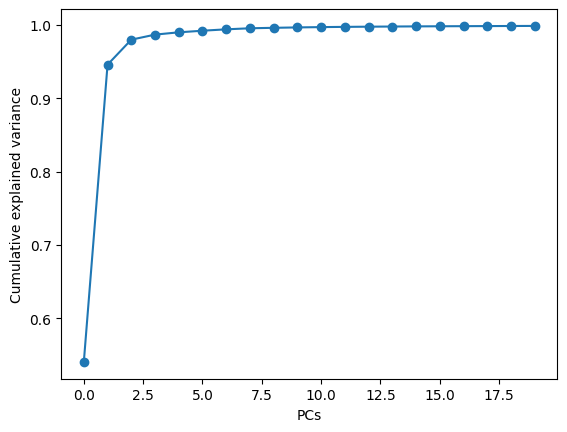

In [11]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("PCs")
plt.ylabel("Cumulative explained variance")
plt.show()

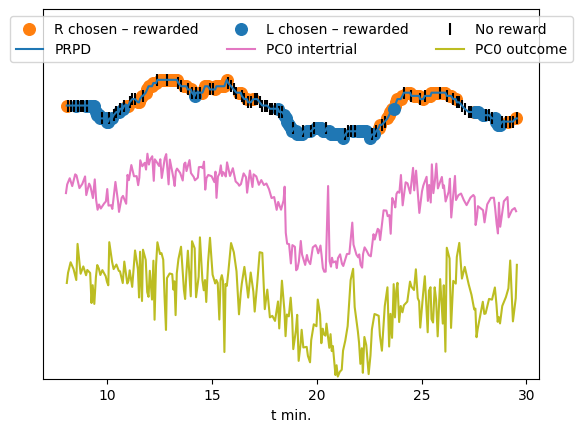

In [12]:
ss = StandardScaler()

u1_prior = PC_SIGN_TO_PRPD_FIX * prior_pca[:,0].reshape(-1, 1)
pc1_iti = ss.fit(u1_prior).transform(u1_prior)
iti_t_min = belief_prior_times/ (1000*60)
u1_post = PC_SIGN_TO_PRPD_FIX * posterior_pca[:,0].reshape(-1, 1)
pc1_outcome = ss.fit(u1_post).transform(u1_post)
outcome_t_min = belief_posterior_times/ (1000*60)
trls = belief_prior_trials
trls['t_min'] = trls['t chosen'] / (1000*60)

shift_prpd_up = 6
right = trls["choice"].str.lower().eq("r")
left = trls["choice"].str.lower().eq("l")


plt.scatter(trls.t_min[right & trls["rewarded"]],
           trls.loc[right & trls["rewarded"], "PRPD"]+shift_prpd_up,
           marker="o", s=70, c='#ff7f0e', label="R chosen – rewarded")
plt.plot(trls['t_min'], trls.PRPD+shift_prpd_up, label='PRPD')
plt.scatter(trls.t_min[left & trls["rewarded"]],
           trls.loc[left & trls["rewarded"], "PRPD"]+shift_prpd_up,
           marker="o", s=70, c='#1f77b4', label="L chosen – rewarded")

plt.plot(iti_t_min, pc1_iti+3, label='PC0 intertrial', c='tab:pink')
plt.scatter(trls.t_min[ ~trls["rewarded"]],
           trls.loc[~trls["rewarded"], "PRPD"]+shift_prpd_up,
           marker="|", s=70, c='black', label="No reward")
plt.plot(outcome_t_min, pc1_outcome, label='PC0 outcome', c='tab:olive')
plt.yticks([])
plt.ylim(-2.5,9)
plt.xlabel('t min.')
plt.legend(ncols=3, loc='upper center')

Train R2: 0.807122656636862
Test R2: 0.6993213941031954
Entire dataset fit R2: 0.795008565550225
Equation:
(PC0)[k+1] = 0.764 PC0[k] + 0.184 c[k] + 0.141 c[k] r[k]


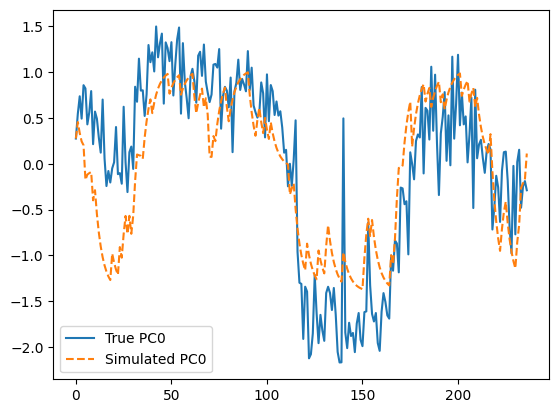

In [ ]:
ss = StandardScaler()
U_ctrl = np.vstack([c, r]).T
# U_ctrl = posterior_pca[:,1:]
# U_ctrl = prior_pca[:,1:]
scU = ss.fit(U_ctrl)
U_ctrl = scU.transform(U_ctrl)

# state trajectories (just the 1D belief axis)
X_state = ss.fit(u1_prior).transform(u1_prior).reshape(-1, 1)


x_lib = ps.PolynomialLibrary(degree=1, include_bias=False)
u_lib = ps.PolynomialLibrary(degree=3, include_bias=False)

k = U_ctrl.shape[1]
n_total = 1 + k
row_x = np.zeros(n_total, dtype=int)
row_u = np.arange(1, n_total, dtype=int)
row_u = np.pad(row_u, (0, n_total - row_u.size), constant_values=row_u[-1])
inputs_map = np.vstack([row_x, row_u])


lib = ps.GeneralizedLibrary([x_lib, u_lib], inputs_per_library=inputs_map)
split_pcnt = 0.6
split_n = int(len(X_state)*split_pcnt)

# base = ps.STLSQ(threshold=2.7, alpha=0.3, normalize_columns=True)
# base = ps.STLSQ(threshold=3, alpha=0.3, normalize_columns=True)
# base = ps.STLSQ(threshold=1.5, alpha=0.5, normalize_columns=True) # with choice
base = ps.STLSQ(threshold=1.3, alpha=0.5, normalize_columns=True) # 0.761 u1[k] + 0.159 c[k] + 0.105 c[k] r[k]
opt = ps.EnsembleOptimizer(opt=base,
                            bagging=True,
                            library_ensemble=True,
                            n_models=40,
                            n_subset=split_n,
                            replace=True)

names_states = ["PC0"]
names_ctrl = ["c", "r"][:U_ctrl.shape[1]]
# names_ctrl = [f'z{i}'for i in np.arange(U_ctrl.shape[1])]
feature_names = names_states + names_ctrl

model = ps.SINDy(
    feature_library=lib,
    optimizer=opt,
    feature_names=feature_names,
    discrete_time=True
)

model.fit(X_state[:split_n], u=U_ctrl[:split_n])
# model.fit(X_state[split_n:], u=U_ctrl[split_n:])

print("Train R2:", model.score(X_state[:split_n], u=U_ctrl[:split_n]))
print("Test R2:", model.score(X_state[split_n:], u=U_ctrl[split_n:]))
# model.fit(X_state, u=U_ctrl)
print("Entire dataset fit R2:", model.score(X_state, u=U_ctrl))
print("Equation:")
model.print(), model.complexity

X_sim = model.simulate(X_state[0], len(X_state), u=U_ctrl)
plt.plot(X_state, label="True PC0")
plt.plot(X_sim, "--", label="Simulated PC0")
plt.legend()
plt.show()

Train R2: 0.7939072357565015
Test R2: 0.7417980388932952
Entire dataset fit R2: 0.800309819139618
Equation:
(PC0)[k+1] = 0.788 PC0[k] + -0.194 PC_out_4[k] + 0.093 PC_out_17[k]


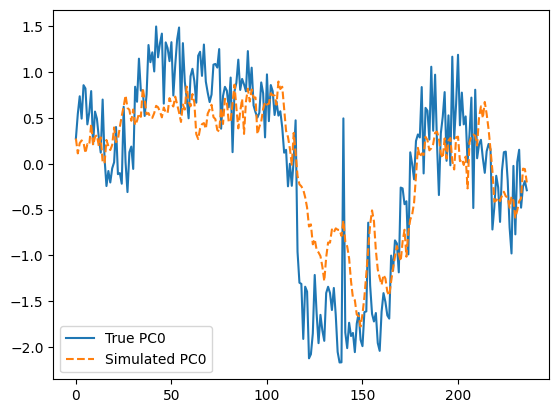

In [176]:
skip_first = 0
X_state = ss.fit(u1_prior[skip_first:]).transform(u1_prior[skip_first:]).reshape(-1, 1)
# X_state = ss.fit(u1_post).transform(u1_post).reshape(-1, 1)
split_pcnt = 0.6
split_n = int(len(X_state)*split_pcnt)
# U_ctrl = posterior_pca[:,1:]
# U_ctrl = prior_pca[:,1:]
prior_pcs = prior_pca[skip_first:,1:]
postr_pcs = posterior_pca[skip_first:,1:]
# select_prior_pcs = [3,4,5,6,7,8]
# select_postr_pcs = [3,4,5,6,7,8]
# prior_pcs = prior_pca[skip_first:,select_prior_pcs]
# postr_pcs = posterior_pca[skip_first:,select_postr_pcs]
U_ctrl = np.hstack([prior_pcs, postr_pcs])
scU = StandardScaler().fit(U_ctrl)
U_ctrl = scU.transform(U_ctrl)
# names_ctrl = [f'PC_iti_{i}'for i in select_prior_pcs] + [f'PC_out_{i+1}'for i in select_postr_pcs]
names_ctrl = [f'PC_iti_{i+1}'for i in np.arange(prior_pcs.shape[1])] + [f'PC_out_{i+1}'for i in np.arange(postr_pcs.shape[1])]
feature_names = names_states + names_ctrl
# with 50% nsplit
# base = ps.STLSQ(threshold=2.7, alpha=0.3, normalize_columns=True)
# base = ps.STLSQ(threshold=0.25, alpha=0.9, normalize_columns=True)  # (u1)[k+1] = 0.748 u1[k] + -0.152 z22[k] + -0.073 z25[k]
# base = ps.STLSQ(threshold=0.25, alpha=0.9, normalize_columns=True) # PC0)[k+1] = 0.727 PC0[k] + -0.101 PC_out_4[k] + -0.084 PC_out_5[k] + -0.075 PC_out_7[k]
# base = ps.STLSQ(threshold=0.23, alpha=0.9, normalize_columns=True) # 0.711 PC0[k] + -0.097 PC_out_4[k] + -0.087 PC_out_5[k] + -0.070 PC_out_7[k] + 0.048 PC_iti_6[k] PC_iti_8[k]

# with 100% n_subset
# base = ps.STLSQ(threshold=0.45, alpha=0.77, normalize_columns=True) # (PC0)[k+1] = 0.739 PC0[k] + -0.328 PC_out_4[k] + -0.118 PC_out_5[k] + 0.241 PC_out_6[k] + -0.012 PC_out_7[k] + -0.026 PC0[k] PC_iti_7[k]
# base = ps.STLSQ(threshold=0.5, alpha=0.77, normalize_columns=True) # (PC0)[k+1] = 0.740 PC0[k] + -0.348 PC_out_4[k] + -0.120 PC_out_5[k] + 0.258 PC_out_6[k] + -0.026 PC0[k] PC_iti_7[k]
# base = ps.STLSQ(threshold=0.5, alpha=0.77, normalize_columns=True) # (PC0)[k+1] = 0.756 PC0[k] + -0.128 PC_out_4[k] + -0.081 PC_out_5[k] + -0.027 PC0[k] PC_iti_7[k]
# base = ps.STLSQ(threshold=0.42, alpha=0.5, normalize_columns=True)  # (PC0)[k+1] = 0.756 PC0[k] + -0.128 PC_out_4[k] + -0.081 PC_out_5[k] + -0.027 PC0[k] PC_iti_7[k]
# + 0.258 PC_out_6[k] maybe help for transition a bit
# base = ps.STLSQ(threshold=0.55, alpha=0.77, normalize_columns=True) # 
# Entire ds R2: 0.7960925651782418
# Complexity: 4
# Equation:
# (PC0)[k+1] = 0.756 PC0[k] + -0.128 PC_out_4[k] + -0.081 PC_out_5[k] + -0.027 PC0[k] PC_iti_7[k]


x_lib = ps.PolynomialLibrary(degree=1, include_bias=False)
u_lib = ps.PolynomialLibrary(degree=1, include_bias=False)

k = U_ctrl.shape[1]
n_total = 1 + k
row_x = np.zeros(n_total, dtype=int)
row_u = np.arange(1, n_total, dtype=int)
row_u = np.pad(row_u, (0, n_total - row_u.size), constant_values=row_u[-1])
inputs_map = np.vstack([row_x, row_u])
lib = ps.GeneralizedLibrary([x_lib, u_lib], inputs_per_library=inputs_map)


# base = ps.STLSQ(threshold=0.047, alpha=0.9, normalize_columns=True) # for degree 3
base = ps.STLSQ(threshold=1.08, alpha=0.1, normalize_columns=True) # for degree 1
opt = ps.EnsembleOptimizer(opt=base,
                            bagging=True,
                            library_ensemble=True,
                            n_models=40,
                            n_subset=split_n,
                            replace=True)
model = ps.SINDy(
    feature_library=lib,
    optimizer=opt,
    feature_names=feature_names,
    discrete_time=True
)
if 0:
	# if split_pcnt<1:
	# 	model.fit(X_state[:split_n], u=U_ctrl[:split_n])
	# 	forward_fit_train = model.score(X_state[:split_n], u=U_ctrl[:split_n])
	# 	forward_fit_test = model.score(X_state[split_n:], u=U_ctrl[split_n:]) 
	# 	model.fit(X_state[split_n:], u=U_ctrl[split_n:])
	# 	backward_fit_test = model.score(X_state[:split_n], u=U_ctrl[:split_n])
	# 	backward_fit_train = model.score(X_state[split_n:], u=U_ctrl[split_n:])
	# 	print("Train R2:", (forward_fit_train+backward_fit_train)/2)
	# 	print("Test R2:", (forward_fit_test+backward_fit_test)/2)
	# model.fit(X_state, u=U_ctrl)
	# print("Entire ds R2:", model.score(X_state, u=U_ctrl))
	# print("Complexity:", model.complexity)
	# print("Equation:")
	# model.print()
 	pass

model.fit(X_state[:split_n], u=U_ctrl[:split_n])
# model.fit(X_state[split_n:], u=U_ctrl[split_n:])

print("Train R2:", model.score(X_state[:split_n], u=U_ctrl[:split_n]))
print("Test R2:", model.score(X_state[split_n:], u=U_ctrl[split_n:]))
# model.fit(X_state, u=U_ctrl)
print("Entire dataset fit R2:", model.score(X_state, u=U_ctrl))
print("Equation:")
model.print(), model.complexity

t = 0
true_x = X_state[t:]
X_sim = model.simulate(X_state[t], len(true_x), u=U_ctrl[t:])
plt.plot(true_x, label="True PC0")
plt.plot(X_sim, "--", label="Simulated PC0")
plt.legend()
plt.show()
# (PC0_prior)[k+1] = 0.738 PC0_prior[k] + -0.133 PC2_post_outcome[k] + -0.082 PC3_post_outcome[k]

In [15]:
X = np.hstack([prior_pca[skip_first:,:], posterior_pca[skip_first:,1:]])[:, np.argwhere(model.coefficients())[:,1:].flatten()]

X.shape

(227, 4)

In [ ]:
scaler = StandardScaler(with_mean=True, with_std=True)
X = np.hstack([prior_pca[skip_first:,:], posterior_pca[skip_first:,1:]])[:, np.argwhere(model.coefficients())[:,1:].flatten()]
Xz = scaler.fit_transform(X)
split = int(0.5 * len(Xz))
X_train, X_test = Xz[:split], Xz[split:]

warnings.filterwarnings("ignore")

lib = ps.PolynomialLibrary(degree=2, include_interaction=True, include_bias=False)
def fit_score(thr, alpha):
    base = ps.STLSQ(threshold=thr, alpha=alpha, normalize_columns=False)
    opt = ps.EnsembleOptimizer(
        opt=base,
        bagging=True, library_ensemble=True,
        n_models=20,
        n_subset=split,
    )
    model = ps.SINDy(
        feature_library=lib,
        optimizer=opt,
        feature_names=["u1","z2","z3","z4"],
        discrete_time=True,
    )
    model.fit(X_train)

    # one-step prediction R2 on train/test
    def r2(xa, xb):
        # xb is next-step ground truth
        Xhat = model.predict(xa[:-1])
        num = ((xb[1:] - Xhat)**2).sum()
        den = ((xb[1:] - xb[1:].mean(0))**2).sum()
        return 1 - num/den

    r2_tr = r2(X_train, X_train)
    r2_te = r2(X_test,  X_test)
    return model, r2_tr, r2_te

# search space
grid_thr = [0.05, 0.1, 0.2, 0.4]
grid_alph = [1e-3, 1e-2, 1e-1]

best = None
for thr, alpha in product(grid_thr, grid_alph):
    m, rtr, rte = fit_score(thr, alpha)
    comp = m.complexity
    score_tuple = (rte, -comp)
    if (best is None) or (score_tuple > best[0]):
        best = (score_tuple, (thr, alpha), (rtr, rte), m)

best_score, (thr, alpha), (r2_tr, r2_te), model = best
print(f"Best discrete SINDy: threshold={thr}, alpha={alpha}, R2_train={r2_tr:.3f}, R2_test={r2_te:.3f}, terms={model.complexity}")
model.print()

Best discrete SINDy: threshold=0.4, alpha=0.001, R2_train=0.291, R2_test=0.260, terms=2
(u1)[k+1] = 0.921 u1[k]
(z2)[k+1] = 0.860 z2[k]
(z3)[k+1] = 0.000
(z4)[k+1] = 0.000


.\mamba\envs\my_msc_proj\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.4) and eliminated all coefficients
  warnings.warn(
.\mamba\envs\my_msc_proj\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.4) and eliminated all coefficients
  warnings.warn(
.\mamba\envs\my_msc_proj\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.4) and eliminated all coefficients
  warnings.warn(
.\mamba\envs\my_msc_proj\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.4) and eliminated all coefficients
  warnings.warn(
.\mamba\envs\my_msc_proj\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.4) and eliminated all coefficients
  warnings.warn(
.\mamba\envs\my_msc_proj\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.4) and e

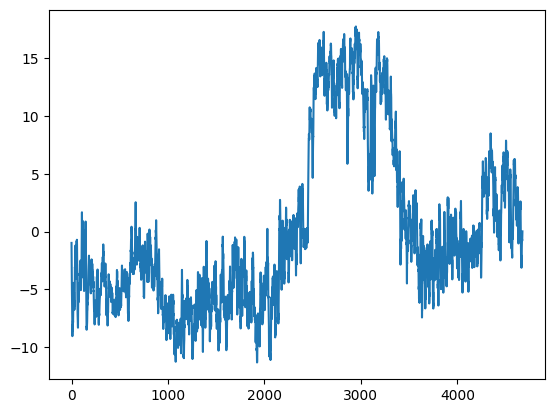

In [17]:
plt.plot(np.convolve(X_pca[:,0].reshape(-1), np.ones(10)/10, 'full'))

In [ ]:
dt = 0.3 # step
t = np.arange(X_pca.shape[0])*dt

ss = StandardScaler()
# U_ctrl = X_pca[:,1:7]
U_ctrl = np.vstack([np.convolve(X_pca[:,i], np.ones(2)/2, 'same') for i in range(1,20)]).T
# U_ctrl = posterior_pca[:,1:]
# U_ctrl = prior_pca[:,1:]
U_ctrl = ss.fit_transform(U_ctrl)

# state trajectories (just the 1D belief axis)
pc0 = np.convolve(-X_pca[:,0], np.ones(2)/2, 'same')
X_state = ss.fit_transform(pc0.reshape(-1, 1)).reshape(-1, 1)


x_lib = ps.PolynomialLibrary(degree=1, include_bias=False)
u_lib = ps.PolynomialLibrary(degree=3, include_bias=False)

k = U_ctrl.shape[1]
n_total = 1 + k
row_x = np.zeros(n_total, dtype=int)
row_u = np.arange(1, n_total, dtype=int)
row_u = np.pad(row_u, (0, n_total - row_u.size), constant_values=row_u[-1])
inputs_map = np.vstack([row_x, row_u])


lib = ps.GeneralizedLibrary([x_lib, u_lib], inputs_per_library=inputs_map)
split_n = int(len(X_state)*0.6)

# base = ps.STLSQ(threshold=2.7, alpha=0.3, normalize_columns=True)
# base = ps.STLSQ(threshold=3, alpha=0.3, normalize_columns=True)
base = ps.STLSQ(threshold=1.5, alpha=0.1, normalize_columns=True)
opt = ps.EnsembleOptimizer(opt=base,
                            bagging=True,
                            library_ensemble=True,
                            n_models=40,
                            n_subset=split_n,
                            replace=True)

names_states = ["u1"]
# names_ctrl = ["c", "r"][:U_ctrl.shape[1]]
names_ctrl = [f'z{i}'for i in np.arange(U_ctrl.shape[1])]
feature_names = names_states + names_ctrl

model = ps.SINDy(
    feature_library=lib,
    optimizer=opt,
    feature_names=feature_names,
    discrete_time=True,
)

model.fit(X_state[:split_n], u=U_ctrl[:split_n], 
        #   t=t[:split_n]
          )
# model.fit(X_state[split_n:], u=U_ctrl[split_n:])

print("Train R2:", model.score(X_state[:split_n], u=U_ctrl[:split_n],
                            #    t=t[:split_n]
                               ))
print("Test R2:", model.score(X_state[split_n:], u=U_ctrl[split_n:],
                            #   t=t[split_n:]
                              ))
# model.fit(X_state, u=U_ctrl, t=t)
# print("Entire dataset fit R2:", model.score(X_state, u=U_ctrl,
#                                             # t=t
#                                             ))
# print("Equation:")
model.print(), model.complexity

Train R2: 0.8114251914776106
Test R2: 0.7877998975926883
Entire dataset fit R2: 0.8344717988672504
Equation:
(u1)[k+1] = 0.907 u1[k] + 0.012 z0[k]^2 + -0.014 z0[k] z1[k]


(None, 3)

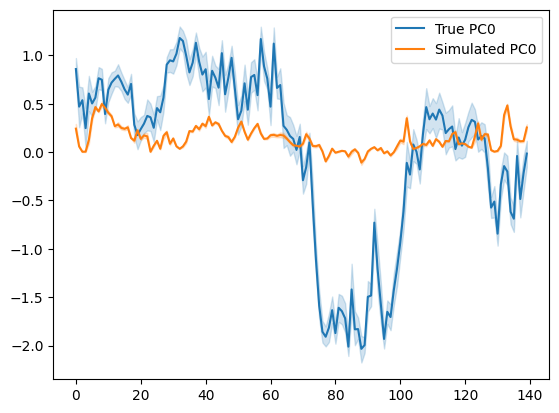

In [ ]:
t0 = 0
# te = 600
# true_x = X_state[t0:te]
true_x = X_state[t0:]
# X_sim = model.simulate(X_state[t0], t[t0:te], u=U_ctrl[t0:te])
X_sim = model.simulate(X_state[t0], len(t[t0:]), u=U_ctrl[t0:])

# sns.lineplot(x=t[t0:te]//10, y=true_x.reshape(-1), label="True PC0")
# sns.lineplot(x=t[t0:te]//10, y=X_sim.reshape(-1), dashes = True, label="Simulated PC0")
sns.lineplot(x=t[t0:]//10, y=true_x.reshape(-1), label="True PC0")
sns.lineplot(x=t[t0:]//10, y=X_sim.reshape(-1), dashes = True, label="Simulated PC0")
plt.legend()
plt.show()